In [1]:
from itertools import product
from functools import partial
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.patches import  Rectangle

from statsmodels.stats.diagnostic import normal_ad
from scipy.stats import linregress

from rdn.stochastic.dendrites import DiffusiveDendrite
from rdn.stochastic.spinemodels import LinearSpineModel
from rdn.stochastic.experiments import linear_experiment


Auxiliary functions

In [2]:
def sample_ks(rng, cv1, cv2, n_spines, dist):
    '''dist : "norm" or "beta" 
    Also if the distribution is norm, we take mean 0.5 for in and 
    0.7 for out, just arbitrarily - shouldnt make a difference
    '''

    if dist == 'norm':
        k_ins = rng.normal(loc=0.5, scale=0.5*cv1, size=n_spines)
        k_outs = rng.normal(loc=0.7, scale=0.7*cv2, size=n_spines)

    elif dist == 'beta':
        abin = 0.5 * (1/cv1**2 - 1)
        about = 0.5 * (1/cv2**2 - 1)

        k_ins = rng.beta(abin, abin, size=n_spines)
        k_outs = rng.beta(about, about, size=n_spines)

    else: raise ValueError('Provided invalid distribution')

    return k_ins, k_outs


def run_process(cvs, rng, dist, n_spines):
    cv1, cv2 = cvs


    k_ins, k_outs = sample_ks(rng, cv1, cv2, n_spines, dist=dist)

    if (k_ins<0).any() or (k_outs<0).any(): 
        ax.remove()
        return -1

    spine_model = LinearSpineModel(k_ins=k_ins, k_outs=k_outs)

    dendrite = DiffusiveDendrite(
        spine_model = spine_model,
        p_outs = p_outs,
        diff_p = diff_p,
        lf_bc = lf_bc,
        rf_bc = rf_bc
    )

    p_outs_t, p_ins_t = dendrite.simulate(time_steps)
    Y = np.log(p_ins_t[-1])

    # ax.hist(Y, bins=30)
    print(normal_ad(Y))

    return p_ins_t


In [3]:
def sample_ks(rng, cv1, cv2, n_spines, dist):
    '''Samples the exhange coefficients
    dist : "norm" or "beta" 
    Also if the distribution is norm, we take mean 0.5 for in and 
    0.7 for out, just arbitrarily - shouldnt make a difference
    '''

    if dist == 'norm':
        k_ins = rng.normal(loc=0.5, scale=0.5*cv1, size=n_spines)
        k_outs = rng.normal(loc=0.7, scale=0.7*cv2, size=n_spines)

    elif dist == 'beta':
        abin = 0.5 * (1/cv1**2 - 1)
        about = 0.5 * (1/cv2**2 - 1)

        k_ins = rng.beta(abin, abin, size=n_spines)
        k_outs = rng.beta(about, about, size=n_spines)

    else: raise ValueError('Provided invalid distribution')

    return k_ins, k_outs


def sample_ratio(cvs, rng, dist, n_spines, n_samples):
    '''Samples the ratios of the exchange coefficients'''
    cv1, cv2 = cvs

    p_vals = np.empty(shape=(n_samples))

    for i in range(n_samples):

        k_ins, k_outs = sample_ks(rng, cv1, cv2, n_spines, dist=dist)

        if (k_ins<0).any() or (k_outs<0).any(): return np.nan

        Y = np.log(k_outs/k_ins)
        p_vals[i] = (normal_ad(Y)[1] > 0.05)


    return p_vals.mean()


def sample_model(cvs, rng, dist, n_spines, n_samples):
    '''Generates the full simulation given the exhange coefficient
    variation coefficients'''

    # This is stupid I know but for now we keep these variables here
    initial_dendritic_count = 1000,
    diffusion_coefficient = 0.001,
    time_steps = 2
    lf_bc = 0
    rf_bc = 0
    ###################

    cv1, cv2 = cvs

    p_vals = np.empty(shape=(n_samples))
    p_outs = np.ones(n_spines, dtype=int)*initial_dendritic_count
    diff_p = np.ones(n_spines) * diffusion_coefficient

    for i in range(n_samples):

        k_ins, k_outs = sample_ks(rng, cv1, cv2, n_spines, dist=dist)
        
        time_scale = 0.001
        k_ins *= time_scale
        k_outs *= time_scale

        if (k_ins<0).any() or (k_outs<0).any(): return np.nan

        spine_model = LinearSpineModel(k_ins=k_ins, k_outs=k_outs)
        dendrite = DiffusiveDendrite(
            spine_model = spine_model,
            p_outs = p_outs,
            diff_p = diff_p,
            lf_bc = lf_bc,
            rf_bc = rf_bc
        )

        _, p_ins_t = dendrite.simulate(time_steps)
        Y = np.log(p_ins_t[-1])

        p_vals[i] = (normal_ad(Y)[1] > 0.05)


    return p_vals.mean()



Sample theoreticals

In [4]:
rng = np.random.default_rng(seed=2025)

n_spines = 1000
n_samples = 1000


### Sample with normals
print('Sampling with normal ks...', end='')
cv1s = np.linspace(0.01,0.22,22)
cv2s = cv1s
result_norm = []
sampler = partial(sample_ratio, rng=rng, dist='norm', n_spines=n_spines, n_samples=n_samples)

with Pool(16) as p:
    result_norm = p.map(sampler, [cv for cv in product(cv1s,cv2s)])

result_norm = np.array(result_norm)
print('done.')


# ### Sample with betas
print('Sampling with beta ks...', end='')
result_beta = []
cv1s = np.linspace(0.01,0.4,40)
cv2s = cv1s
sampler = partial(sample_ratio, rng=rng, dist='beta', n_spines=n_spines, n_samples=n_samples)

with Pool(16) as p:
    result_beta = p.map(sampler, [cv for cv in product(cv1s,cv2s)])

result_beta = np.array(result_beta)
print('done.')

Sampling with normal ks...done.
Sampling with beta ks...done.


# Figure S8

In [5]:
def plot_k_distributions(ax, cv1, cv2, dist='norm'):
    ''' Again dist is either "norm" or "beta". I'm putting the default 
    argument not to have to change the code written so far.
    '''

    if dist=='norm':
        k_ins = rng.normal(loc=0.2, scale=0.2*cv1, size=n_spines)
        k_outs = rng.normal(loc=0.4, scale=0.4*cv2, size=n_spines)

    elif dist=='beta':
        abin = 0.5 * (1/cv1**2 - 1)
        about = 0.5 * (1/cv2**2 - 1)
        k_ins = rng.beta(abin, abin, size=n_spines)
        k_outs = rng.beta(about, about, size=n_spines)
    
    else: raise ValueError('Provided invalid distribution.')

    ax.hist(k_ins, bins=30, density=True, color='navy')
    ax.hist(k_outs, bins=30, density=True, color='cornflowerblue')

    ax.set_xlim(0,1)
    ax.set_ylim(0,40)
    ax.set_xlabel(r'Exhange rates $k_{in}$ and $k_{out}$', fontsize=12)
    ax.set_ylabel('pdf', fontsize=12)

    axins = ax.inset_axes((0.5,0.4,0.45,0.55))
    ax = axins
    ax.hist(np.log(k_ins/k_outs), bins=30, density=True, color='firebrick')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r'$\log k_{in} / k_{out}$', fontsize=10)
    ax.set_title(r'$CV_{{in}}={}$  $CV_{{out}}={}$'.format(cv1, cv2),y=1.2, ha='center', x=0)

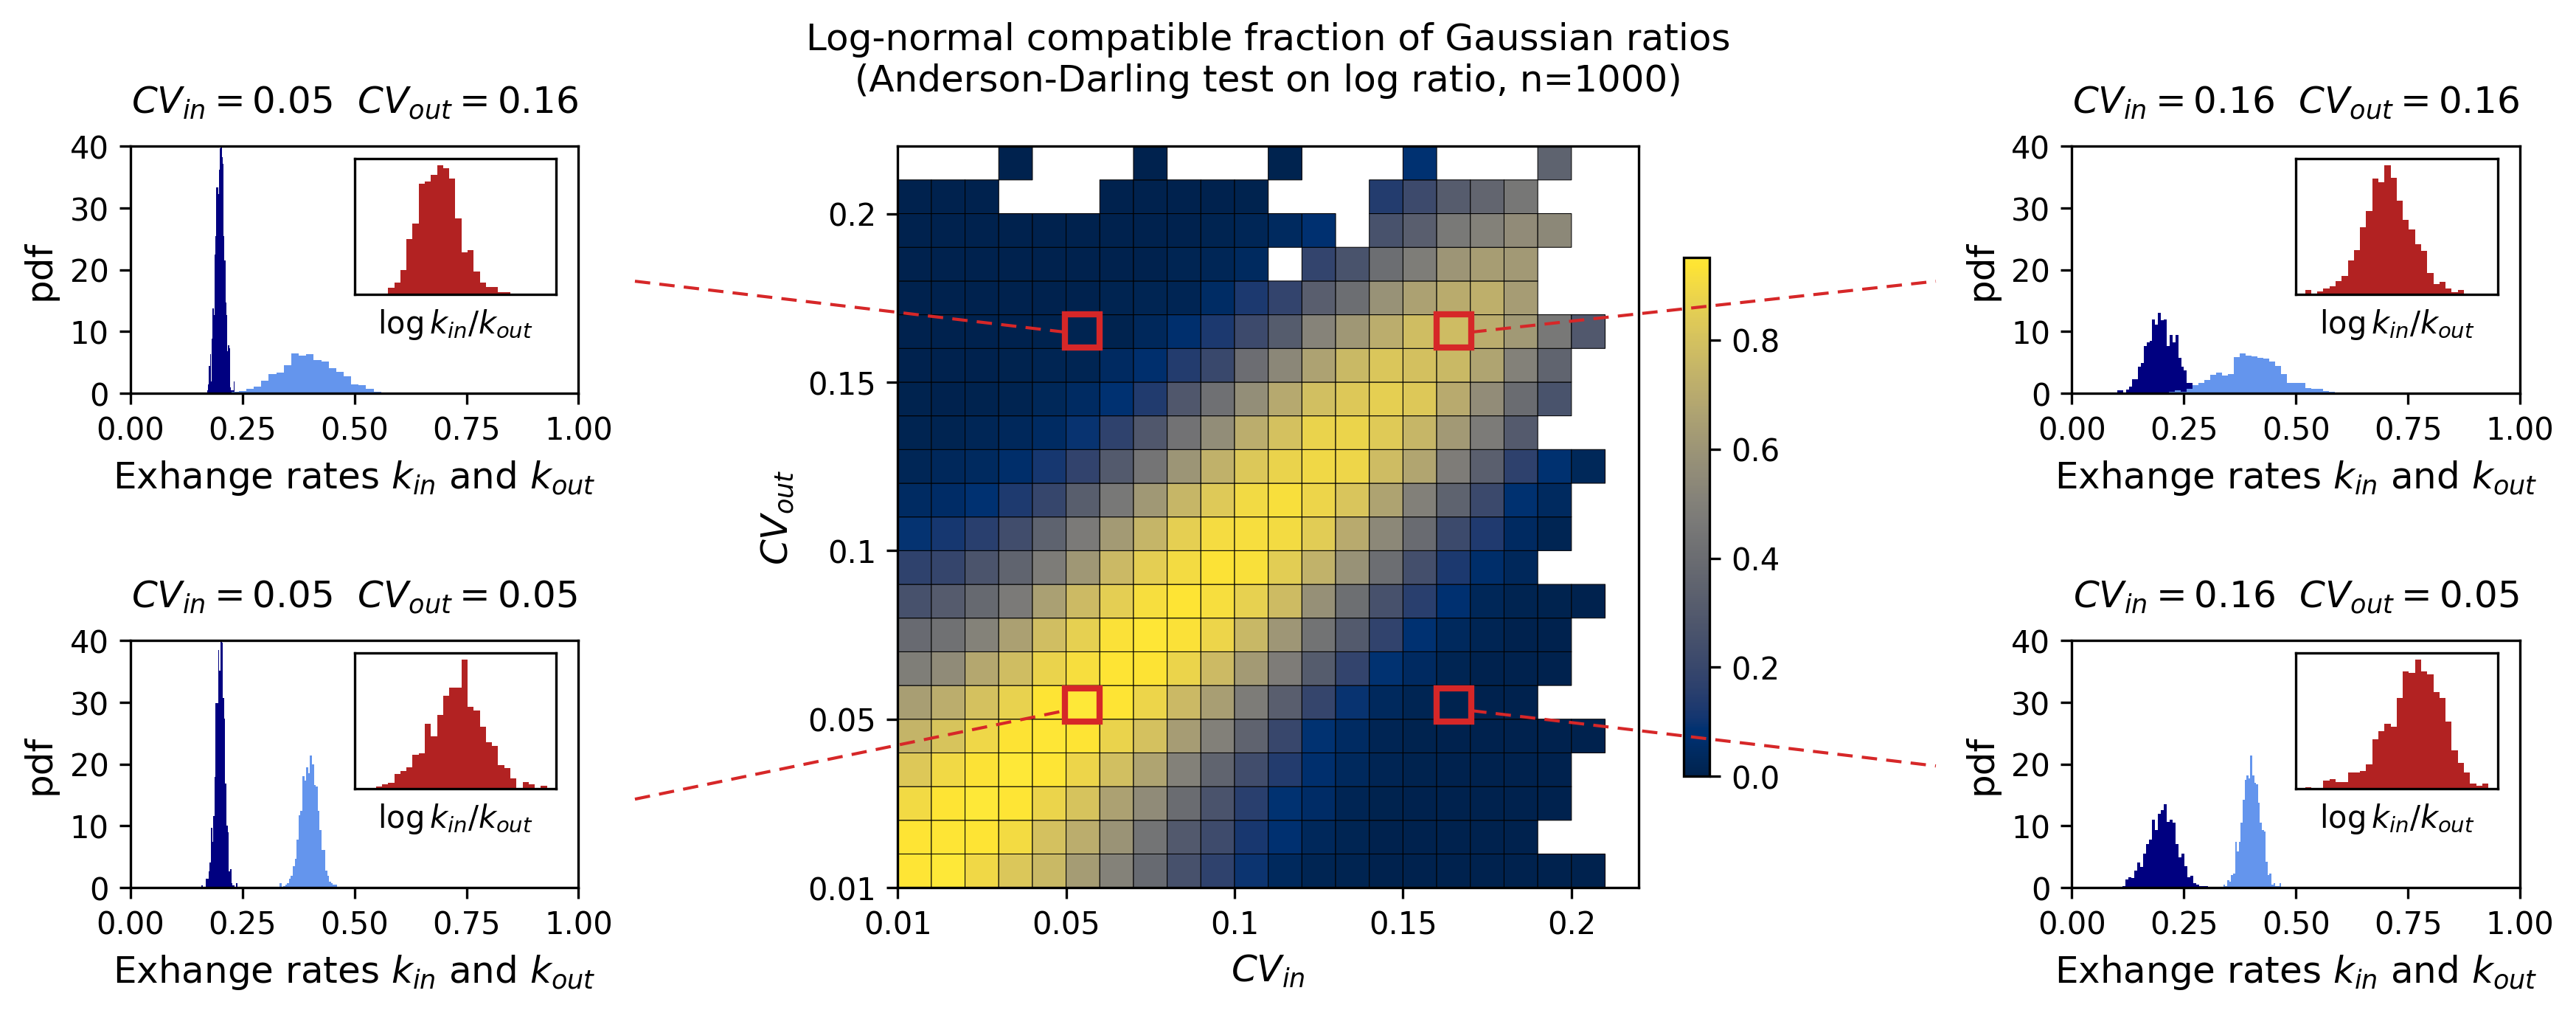

In [6]:
fig = plt.figure(figsize=(12,5), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=(1,2,1,))
fig.subplots_adjust(wspace=0.5, hspace=1, left=0.05, bottom=0.2, right=0.95, top=0.87)

ax = fig.add_subplot(gs[0,0])
plot_k_distributions(ax, 0.05, 0.16)

ax = fig.add_subplot(gs[1,0])
plot_k_distributions(ax, 0.05, 0.05)

ax = fig.add_subplot(gs[0,2])
plot_k_distributions(ax, 0.16, 0.16)

ax = fig.add_subplot(gs[1,2])
plot_k_distributions(ax, 0.16, 0.05)

ax = fig.add_subplot(gs[:,1])

c = ax.pcolor(
    result_norm.reshape(22, -1), # 22 is the len of cv samples
    cmap='cividis',
    edgecolors='black',
)
ax.set_aspect('equal')

fig.colorbar(c, fraction=0.1, shrink=0.7)

ax.set_xticks([0,5,10,15,20], [0.01,0.05,0.10, 0.15,0.20])
ax.set_yticks([0,5,10,15,20], [0.01,0.05,0.10, 0.15,0.20])
ax.set_xlabel(r'$CV_{in}$', fontsize=12)
ax.set_ylabel(r'$CV_{out}$', fontsize=12)
ax.set_title('Log-normal compatible fraction of Gaussian ratios\n(Anderson-Darling test on log ratio, n=1000)', y=1.05)


# I hate this but whatever
fig.add_artist(lines.Line2D([0.24,0.402], [0.748,0.702], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.24,0.402], [0.28,0.36], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.555,0.73], [0.36,0.31], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.555,0.73], [0.702,0.748], linewidth=1, color='tab:red', linestyle=(0,(5,3))))

fig.add_artist(Rectangle((0.402,0.688,), 0.013,0.03, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.402,0.35,), 0.013,0.03, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.542,0.35,), 0.013,0.03, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.542,0.688,), 0.013,0.03, facecolor='none', edgecolor='tab:red', linewidth=2))

# plt.savefig('figures-paper/supplementary/log-from-norm-sample.png', dpi=300)

# Figure S9

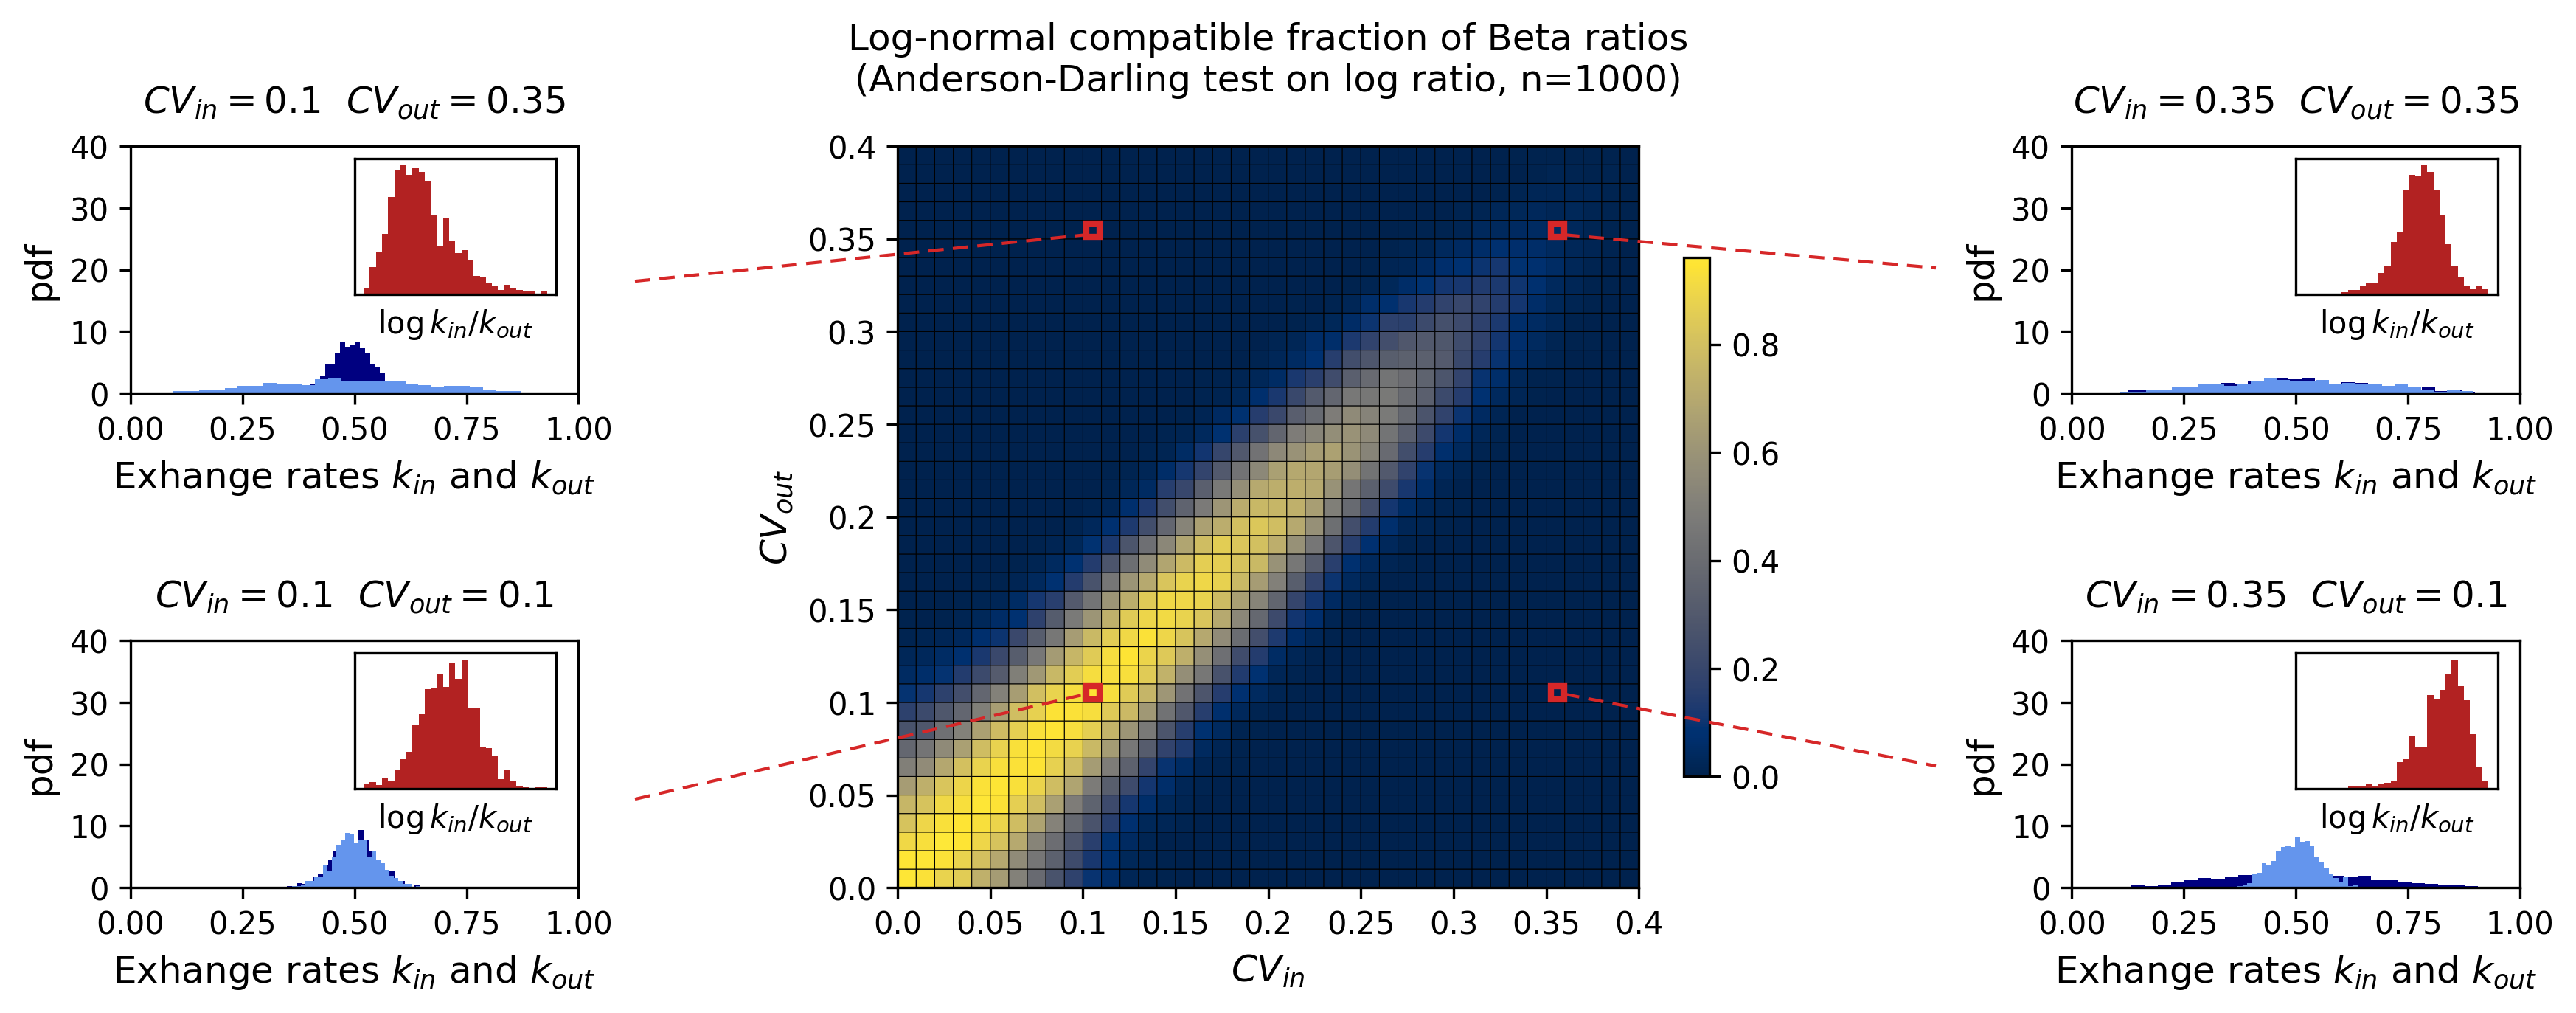

In [7]:
fig = plt.figure(figsize=(12,5), dpi=300)
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=(1,2,1,))
fig.subplots_adjust(wspace=0.5, hspace=1, left=0.05, bottom=0.2, right=0.95, top=0.87)

ax = fig.add_subplot(gs[0,0])
plot_k_distributions(ax, 0.1, 0.35, dist='beta')

ax = fig.add_subplot(gs[1,0])
plot_k_distributions(ax, 0.1, 0.1, dist='beta')

ax = fig.add_subplot(gs[0,2])
plot_k_distributions(ax, 0.35, 0.35, dist='beta')

ax = fig.add_subplot(gs[1,2])
plot_k_distributions(ax, 0.35, 0.1, dist='beta')

ax = fig.add_subplot(gs[:,1])

cmap = plt.get_cmap('cividis')
cmap.set_bad(color='black')

c = ax.pcolor(
    result_beta.reshape(40, -1), # 50 is len of cv samples
    cmap=cmap,
    edgecolors='black',
)
ax.set_aspect('equal')

fig.colorbar(c, fraction=0.1, shrink=0.7)

ax.set_xticks(np.arange(0,41,5), np.arange(0,41,5)/100)
ax.set_yticks(np.arange(0,41,5), np.arange(0,41,5)/100)

ax.set_xlabel(r'$CV_{in}$', fontsize=12)
ax.set_ylabel(r'$CV_{out}$', fontsize=12)
ax.set_title('Log-normal compatible fraction of Beta ratios\n(Anderson-Darling test on log ratio, n=1000)', y=1.05)


# I hate this but whatever
fig.add_artist(lines.Line2D([0.24,0.41], [0.748,0.79], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.24,0.41], [0.28,0.375], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.59,0.73], [0.375,0.31], linewidth=1, color='tab:red', linestyle=(0,(5,3))))
fig.add_artist(lines.Line2D([0.59,0.73], [0.79,0.76], linewidth=1, color='tab:red', linestyle=(0,(5,3))))

fig.add_artist(Rectangle((0.41,0.788,), 0.0051,0.012, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.41,0.37,), 0.0051,0.012, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.585,0.37,), 0.0051,0.012, facecolor='none', edgecolor='tab:red', linewidth=2))
fig.add_artist(Rectangle((0.585,0.788,), 0.0051,0.012, facecolor='none', edgecolor='tab:red', linewidth=2))


# plt.savefig('figures-paper/supplementary/log-from-beta-sample.png', dpi=300)

Sampling with stochastic simulation

In [8]:
rng = np.random.default_rng(seed=2025)

n_spines = 1000
n_samples = 1000


### Sample with normals
print('Sampling with normal ks...', end='')
cv1s = np.linspace(0.01,0.22,22)
cv2s = cv1s
result_norm = []
sampler = partial(sample_model, rng=rng, dist='norm', n_spines=n_spines, n_samples=n_samples)

with Pool(16) as p:
    result_norm = p.map(sampler, [cv for cv in product(cv1s,cv2s)])

result_norm = np.array(result_norm)
print('done.')


# ### Sample with betas
print('Sampling with beta ks...', end='')
result_beta = []
cv1s = np.linspace(0.01,0.4,40)
cv2s = cv1s
sampler = partial(sample_model, rng=rng, dist='beta', n_spines=n_spines, n_samples=n_samples)

with Pool(16) as p:
    result_beta = p.map(sampler, [cv for cv in product(cv1s,cv2s)])

result_beta = np.array(result_beta)
print('done.')

Sampling with normal ks...

/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by zero encountered in log
  Y = np.log(p_ins_t[-1])
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/statsmodels/stats/_adnorm.py:48: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by zero encountered in log
  Y = np.log(p_ins_t[-1])
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/statsmodels/stats/_adnorm.py:48: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by 

done.
Sampling with beta ks...

/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by zero encountered in log
  Y = np.log(p_ins_t[-1])
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/statsmodels/stats/_adnorm.py:48: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by zero encountered in log
  Y = np.log(p_ins_t[-1])
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janko/.virtualenvs/pypesto13/lib/python3.13/site-packages/statsmodels/stats/_adnorm.py:48: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s
/tmp/ipykernel_602094/4076915881.py:81: RuntimeWarning: divide by 

done.


# Figure S10

Text(0.5, 1.05, 'Log-normal compatible fraction,\nstochastic dendrite simulation\n(Beta exchange rates, n=1000)')

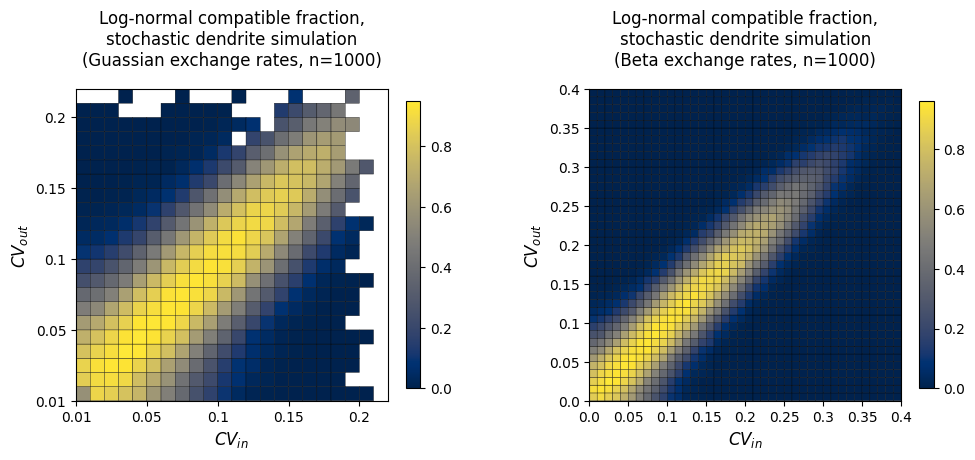

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.4, hspace=0.2, left=0.07, bottom=0.05, right=0.95, top=0.87)
# fig.subplots_adjust(wspace=0.5, hspace=1, left=0.05, bottom=0.2, right=0.95, top=0.87)


ax = axs[0]
c = ax.pcolor(
    result_norm.reshape(22, -1), # 22 is the len of cv samples
    cmap='cividis',
    edgecolors='black',
)
ax.set_aspect('equal')

fig.colorbar(c, fraction=0.1, shrink=0.7)

ax.set_xticks([0,5,10,15,20], [0.01,0.05,0.10, 0.15,0.20])
ax.set_yticks([0,5,10,15,20], [0.01,0.05,0.10, 0.15,0.20])
ax.set_xlabel(r'$CV_{in}$', fontsize=12)
ax.set_ylabel(r'$CV_{out}$', fontsize=12)
ax.set_title(
    'Log-normal compatible fraction,\n'
    'stochastic dendrite simulation\n'
    '(Guassian exchange rates, n=1000)',
    y=1.05
)

ax = axs[1]
c = ax.pcolor(
    result_beta.reshape(40, -1), # 50 is len of cv samples
    cmap='cividis',
    edgecolors='black',
)

ax.set_aspect('equal')

fig.colorbar(c, fraction=0.1, shrink=0.7)

ax.set_xticks(np.arange(0,41,5), np.arange(0,41,5)/100)
ax.set_yticks(np.arange(0,41,5), np.arange(0,41,5)/100)

ax.set_xlabel(r'$CV_{in}$', fontsize=12)
ax.set_ylabel(r'$CV_{out}$', fontsize=12)
ax.set_title(
    'Log-normal compatible fraction,\n'
    'stochastic dendrite simulation\n'
    '(Beta exchange rates, n=1000)',
    y=1.05
)


# plt.savefig('figures-paper/supplementary/log-model-sample.png', dpi=300)

# Figure S11

Text(0, 0.5, 'Change at step t+1')

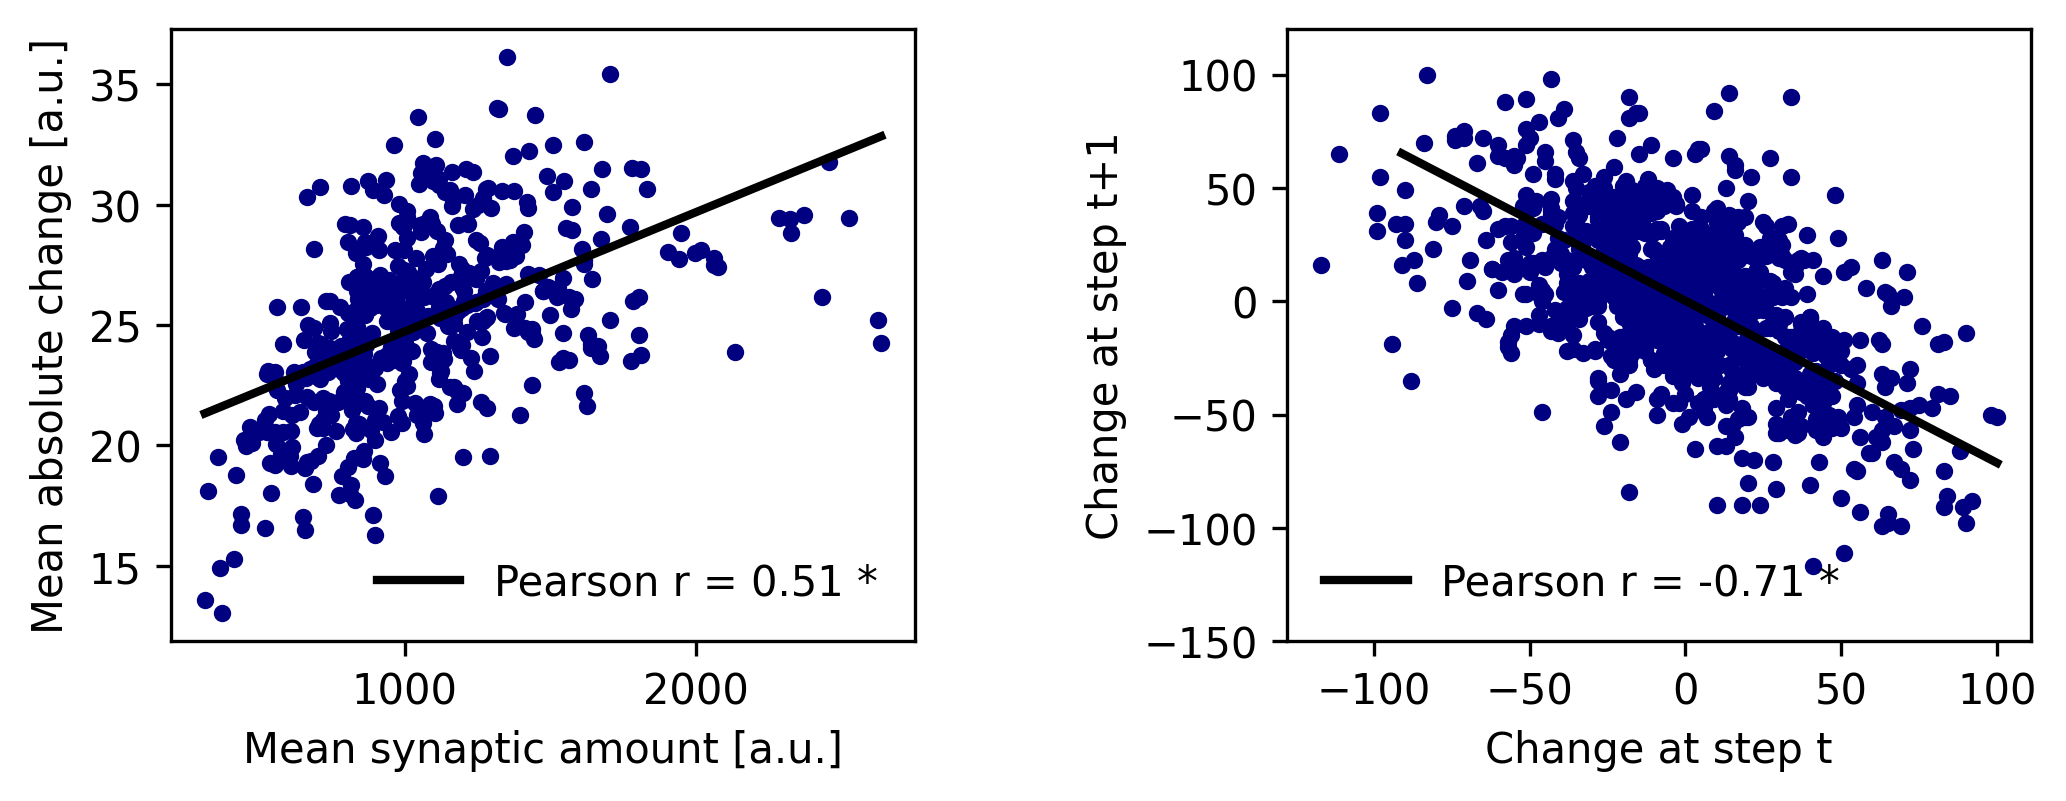

In [10]:
c = 10

pouts, pins = linear_experiment(
    500,
    a_beta_in = c,
    a_beta_out = c,
    b_beta_in = c,
    b_beta_out = c
)

pins_means = pins.mean(axis=0)
deltas = pins[1:] - pins[:-1]
deltas_mean = np.abs(deltas).mean(axis=0)


fig, axs = plt.subplots(1,2,figsize=(8,3), dpi=300)
fig.subplots_adjust(wspace=0.5, bottom=0.2)

ax = axs[0]
s,i,r,p,e = linregress(pins_means, deltas_mean)
ax.scatter(pins_means, deltas_mean, color='navy', s=10)
X = np.array([pins_means.min(), pins_means.max()])
ax.plot(X, i + s*X, c='black', linewidth=2, label=f'Pearson r = {r:.2f} *')

ax.legend(frameon=False)
ax.set_xlabel('Mean synaptic amount [a.u.]')
ax.set_ylabel('Mean absolute change [a.u.]')


ax = axs[1]

# We take only 10 spines not to overcrowd the plot. The correlations is
# highly significant also with the whole dataset
for i in range(10):
    ax.scatter(deltas[:-1,i], deltas[1:,i], color='navy', s=10)

s,i,r,p,e = linregress(deltas[:-1,0], deltas[1:,0])
# ax.scatter(pins_means, deltas_mean, color='navy', s=10)
X = np.array([deltas[:,0].min(), deltas[:,0].max()])
ax.plot(X, i + s*X, c='black', linewidth=2, label=f'Pearson r = {r:.2f} *')

ax.legend(frameon=False, loc='lower left')
ax.set_ylim(-150,120)
ax.set_xlabel('Change at step t')
ax.set_ylabel('Change at step t+1')


# plt.savefig('figures-paper/supplementary/log-model-variations.png', dpi=300)